Imports & Configuration

In [7]:
import os
from pathlib import Path
import cv2
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
import pandas as pd
import random

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# plotting
import matplotlib.pyplot as plt

# ImageNet statistics (numpy)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# -----------------------------
# EDIT THESE PATHS / HYPERPARAMS
# -----------------------------
DATA_ROOT = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech"
OUT_DIR = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs"
TARGET_SIZE = (1024, 1024)  # (W, H) — target grid for images & density_full
JPEG_QUALITY = 85
DENSITY_SIGMA = 4
GT_DOWNSAMPLE = 8  # checklist step 3 -> downsample factor
OVERWRITE = True

# SAVE options for final tensors
SAVE_TENSORS = True               # whether to save per-sample .pt tensors
SAVE_TENSORS_DIR = "tensors"      # subfolder under OUT_DIR
SAVE_NORMALIZED = True          # if True, images saved already normalized by ImageNet mean/std

# Ensure outdir exists
DATA_ROOT = Path(DATA_ROOT)
OUT_DIR = Path(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Configuration loaded.")
print(" DATA_ROOT:", DATA_ROOT)
print(" OUT_DIR:", OUT_DIR)
print(" TARGET_SIZE (W,H):", TARGET_SIZE)
print(" JPEG_QUALITY:", JPEG_QUALITY)
print(" DENSITY_SIGMA:", DENSITY_SIGMA)
print(" GT_DOWNSAMPLE:", GT_DOWNSAMPLE)
print(" OVERWRITE:", OVERWRITE)
print(" SAVE_TENSORS:", SAVE_TENSORS)
print(" SAVE_NORMALIZED:", SAVE_NORMALIZED)

# Quick check: required libs available and folders accessible
assert DATA_ROOT.exists(), f"DATA_ROOT does not exist: {DATA_ROOT}"
assert OUT_DIR.exists(), f"OUT_DIR not created: {OUT_DIR}"
print("Cell 1 check: OK (paths exist).")


Configuration loaded.
 DATA_ROOT: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech
 OUT_DIR: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs
 TARGET_SIZE (W,H): (1024, 1024)
 JPEG_QUALITY: 85
 DENSITY_SIGMA: 4
 GT_DOWNSAMPLE: 8
 OVERWRITE: True
 SAVE_TENSORS: True
 SAVE_NORMALIZED: True
Cell 1 check: OK (paths exist).


Helper functions (clean & documented)


This cell contains deterministic, simple helper functions used by the preprocessing pipeline.


- `load_gt_points`: reads the ShanghaiTech `.mat` ground-truth points.
- `preprocess_image_cv2`: BGR→RGB, resize, JPEG encode/decode to simulate disk artifact, scale to `[0,1]`.
- `scale_points`: scale point coordinates from original image size to `TARGET_SIZE`.
- `generate_density_map`: rasterize points to a zero map, apply Gaussian smoothing, then renormalize so the integral equals the number of points.

In [8]:
def load_gt_points(mat_path):
    """Load GT points from ShanghaiTech .mat (returns Nx2 array with [x,y])."""
    d = loadmat(str(mat_path))
    pts = d['image_info'][0][0][0][0][0]
    return pts.astype(np.float32)

def preprocess_image_cv2(img_bgr, target_size=(512,512), compress_quality=85):
    """Resize (cv2), convert BGR->RGB and compress using JPEG quality.
       Returns image in RGB with float32 range [0,1].
    """
    target_w, target_h = target_size
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (target_w, target_h), interpolation=cv2.INTER_AREA)

    # compress to JPEG and read back (simulate on-disk)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compress_quality]
    success, enc = cv2.imencode('.jpg', cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR), encode_param)
    if success:
        img_resized = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    img_out = img_resized.astype(np.float32) / 255.0
    return img_out  # shape (H, W, 3), float32

def scale_points(points, orig_shape, target_size):
    """Scale [x,y] points from orig_shape (H_orig, W_orig) to target_size (W_target,H_target)."""
    H_orig, W_orig = orig_shape[:2]
    W_t, H_t = target_size
    pts = points.astype(np.float32).copy()
    pts[:,0] = pts[:,0] * (W_t / W_orig)
    pts[:,1] = pts[:,1] * (H_t / H_orig)
    return pts

def generate_density_map(H, W, points_scaled, sigma=4):
    """Generate density map of shape (H, W). After gaussian smoothing,
       rescale the density so sum == number of points (integral equals count).
    """
    density = np.zeros((H, W), dtype=np.float32)
    for p in points_scaled:
        x = int(round(p[0]))
        y = int(round(p[1]))
        if x < 0 or x >= W or y < 0 or y >= H:
            continue
        density[y, x] += 1.0
    density = gaussian_filter(density, sigma=sigma, mode='constant')
    s = density.sum()
    if s > 0:
        density = density * (len(points_scaled) / s)
    return density

print("Cell 2 check: helper functions defined.")


Cell 2 check: helper functions defined.


`process_split` function


This single function handles processing one dataset split (e.g., `part_A/train_data`). It:
- reads images and corresponding `.mat` files,
- runs the preprocessing pipeline,
- generates density maps on the target grid,
- downsamples density by `GT_DOWNSAMPLE` and multiplies by `GT_DOWNSAMPLE**2` to preserve counts,
- saves images (`.jpg`), downsampled density (`.npy`), and full-grid density (`.npy`).


A small manifest dict for each sample is returned for later use.


In [9]:
def process_split(part_name, split_name, data_root, out_root,
                  target_size=(1024,1024), jpeg_quality=85, sigma=4, overwrite=False,
                  gt_downsample=8):
    """Process one split and return a list of manifest dicts.

    Manifest fields: part, split, img_name, img_path, density_path, density_full_path, gt_count, gt_count_downsampled
    """
    images_dir = data_root / part_name / split_name / "images"
    gt_dir = data_root / part_name / split_name / "ground-truth"

    out_images_dir = out_root / part_name / split_name / "images"
    out_density_dir = out_root / part_name / split_name / "density"
    out_density_full = out_root / part_name / split_name / "density_full"
    out_images_dir.mkdir(parents=True, exist_ok=True)
    out_density_dir.mkdir(parents=True, exist_ok=True)
    out_density_full.mkdir(parents=True, exist_ok=True)

    manifest = []

    if not images_dir.exists():
        print(f"Warning: images dir missing: {images_dir} — skipping.")
        return manifest

    img_files = sorted([f for f in images_dir.iterdir() if f.suffix.lower() in ('.jpg', '.png', '.jpeg')])
    for img_path in tqdm(img_files, desc=f"{part_name}/{split_name}"):
        base = img_path.stem
        mat_path = gt_dir / f"GT_{base}.mat"
        if not mat_path.exists():
            print(f"Missing GT {mat_path.name} for image {img_path.name} — skipping.")
            continue

        out_img = out_images_dir / (base + ".jpg")
        out_den = out_density_dir / (base + ".npy")
        out_den_full = out_density_full / (base + ".npy")

        if out_img.exists() and out_den.exists() and out_den_full.exists() and not overwrite:
            den = np.load(out_den)
            manifest.append({
                "part": part_name, "split": split_name, "img_name": base,
                "img_path": str(out_img), "density_path": str(out_den), "density_full_path": str(out_den_full),
                "gt_count": float(den.sum())
            })
            continue

        # read image and points
        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"Failed to read {img_path}; skipping.")
            continue
        orig_h, orig_w = img_bgr.shape[:2]

        points = load_gt_points(mat_path)
        img_proc = preprocess_image_cv2(img_bgr, target_size=target_size, compress_quality=jpeg_quality)
        points_scaled = scale_points(points, (orig_h, orig_w), target_size)

        W_t, H_t = target_size
        density_full = generate_density_map(H_t, W_t, points_scaled, sigma=sigma)

        # Downsample + scale
        if gt_downsample != 1:
            fx = 1.0 / gt_downsample
            den_ds = cv2.resize(density_full, dsize=(0, 0), fx=fx, fy=fx, interpolation=cv2.INTER_AREA)
            den_ds = den_ds.astype(np.float32)
            den_ds *= (gt_downsample ** 2)  # multiply by 64 when gt_downsample=8
        else:
            den_ds = density_full.astype(np.float32)

        # save image (convert RGB->BGR for cv2 and 0-255)
        img_to_save = (np.clip(img_proc, 0.0, 1.0) * 255.0).astype(np.uint8)[:, :, ::-1]
        cv2.imwrite(str(out_img), img_to_save, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])

        np.save(str(out_den), den_ds.astype(np.float32))
        np.save(str(out_den_full), density_full.astype(np.float32))

        manifest.append({
            "part": part_name, "split": split_name, "img_name": base,
            "img_path": str(out_img), "density_path": str(out_den), "density_full_path": str(out_den_full),
            "gt_count": float(density_full.sum()), "gt_count_downsampled": float(den_ds.sum())
        })

    return manifest

# quick check: function available
print("Cell 3 check: process_split() defined.")


Cell 3 check: process_split() defined.


Run preprocessing (Parts A & B)


This cell runs `process_split` for all four canonical splits used in ShanghaiTech (A/B × train/test). It collects a manifest and stores it as `preprocess_manifest.csv` in `OUT_DIR`.


> **Note:** This step can be slow depending on dataset size; run in a terminal or notebook cell and wait for `tqdm` progress.


---

In [10]:
# Run preprocessing (Parts A & B) + verify manifest
all_manifest = []
for part, split in [("part_A", "train_data"), ("part_A", "test_data"), ("part_B", "train_data"), ("part_B", "test_data")]:
    m = process_split(part, split, DATA_ROOT, OUT_DIR, target_size=TARGET_SIZE, jpeg_quality=JPEG_QUALITY, sigma=DENSITY_SIGMA, overwrite=OVERWRITE, gt_downsample=GT_DOWNSAMPLE)
    all_manifest.extend(m)

manifest_df = pd.DataFrame(all_manifest)
manifest_csv = OUT_DIR / "preprocess_manifest.csv"
manifest_df.to_csv(manifest_csv, index=False)

print("Preprocessing finished.")
print("Total samples processed:", len(manifest_df))
print("Manifest saved to:", manifest_csv)

# Verification checks
assert isinstance(manifest_df, pd.DataFrame)
if len(manifest_df) > 0:
    # check a few required columns exist
    required_cols = {'img_path', 'density_path', 'density_full_path', 'gt_count'}
    assert required_cols.issubset(set(manifest_df.columns)), f"Manifest missing columns: {required_cols - set(manifest_df.columns)}"
    print("Cell 4 check: OK (manifest created with required columns).")
else:
    print("Cell 4 check: WARNING (manifest empty).")


part_A/train_data:   0%|          | 0/300 [00:00<?, ?it/s]

part_A/test_data:   0%|          | 0/182 [00:00<?, ?it/s]

part_B/train_data:   0%|          | 0/400 [00:00<?, ?it/s]

part_B/test_data:   0%|          | 0/316 [00:00<?, ?it/s]

Preprocessing finished.
Total samples processed: 1198
Manifest saved to: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs\preprocess_manifest.csv
Cell 4 check: OK (manifest created with required columns).


Quick visual & numeric verification


A single random sample is displayed and numeric sums are printed to verify that the downsampled density sums equal the full-grid density sums (within floating error).


Sample metadata: {'part': 'part_B', 'split': 'test_data', 'img_name': 'IMG_289', 'img_path': 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\part_B\\test_data\\images\\IMG_289.jpg', 'density_path': 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\part_B\\test_data\\density\\IMG_289.npy', 'density_full_path': 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\part_B\\test_data\\density_full\\IMG_289.npy', 'gt_count': 45.0, 'gt_count_downsampled': 45.0}
Sum full-grid density: 45.0000
Sum downsampled density (after *8^2): 45.0000


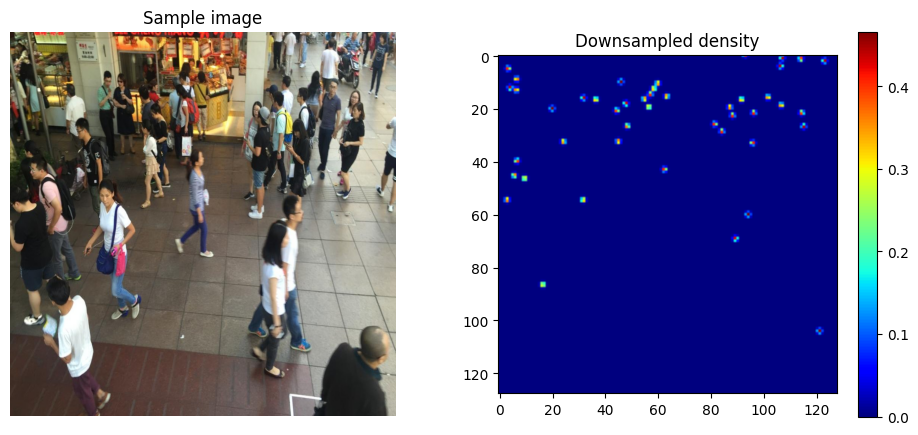

Cell 5 check: OK (sample visualized and sums printed).


In [11]:
#  Quick visual & numeric verification of one random sample
if len(manifest_df) == 0:
    print("No samples found in manifest — please run preprocessing first.")
else:
    sample = manifest_df.sample(1).iloc[0]
    print("Sample metadata:", sample.to_dict())

    img = cv2.imread(sample['img_path'])
    if img is None:
        raise RuntimeError(f"Failed to read image at {sample['img_path']}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    den_ds = np.load(sample['density_path'])
    den_full = np.load(sample['density_full_path'])

    print(f"Sum full-grid density: {den_full.sum():.4f}")
    print(f"Sum downsampled density (after *{GT_DOWNSAMPLE}^2): {den_ds.sum():.4f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title('Sample image'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(den_ds, cmap='jet'); plt.title('Downsampled density'); plt.colorbar()
    plt.show()

    print("Cell 5 check: OK (sample visualized and sums printed).")


In [12]:
# Save per-sample tensors (images + downsampled GT) as .pt files
def save_all_tensors(manifest_df, out_dir, save_folder_name="tensors", save_normalized=False):
    """
    Saves each sample as: out_dir / save_folder_name / <part> / <split> / <IMG_NAME>.pt
    Each .pt contains dict: {'image': tensor(3,H,W), 'density': tensor(1,Hds,Wds), 'img_path', 'density_path', 'gt_sum'}
    image tensor is in [0,1] (NOT normalized) unless save_normalized=True
    """
    base_dir = out_dir / save_folder_name
    base_dir.mkdir(parents=True, exist_ok=True)
    saved = 0

    for idx, row in manifest_df.iterrows():
        part = row['part']
        split = row['split']
        img_path = Path(row['img_path'])
        den_path = Path(row['density_path'])

        tgt_dir = base_dir / part / split
        tgt_dir.mkdir(parents=True, exist_ok=True)
        save_file = tgt_dir / (img_path.stem + ".pt")

        # load image and density
        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"Warning: failed to read {img_path}, skipping.")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # H,W,3
        img_t = torch.from_numpy(img_rgb).permute(2,0,1).contiguous()  # 3,H,W

        if save_normalized:
            mean = torch.from_numpy(IMAGENET_MEAN).view(3,1,1)
            std = torch.from_numpy(IMAGENET_STD).view(3,1,1)
            img_t = (img_t - mean) / std

        den = np.load(str(den_path)).astype(np.float32)  # Hds,Wds
        den_t = torch.from_numpy(den).unsqueeze(0)  # 1,Hds,Wds

        torch.save({
            'image': img_t,
            'density': den_t,
            'img_path': str(img_path),
            'density_path': str(den_path),
            'gt_sum': float(den_t.sum().item())
        }, str(save_file))

        saved += 1
        if saved % 200 == 0:
            print(f"Saved {saved} tensors...")

    print(f"Saved total {saved} tensor files under {base_dir}")
    return base_dir

# Run save step (only if manifest non-empty)
if SAVE_TENSORS:
    if len(manifest_df) == 0:
        print("Skipping save_all_tensors because manifest is empty.")
        tensors_base = None
    else:
        print("Saving .pt tensors for all samples (this may take time)...")
        tensors_base = save_all_tensors(manifest_df, OUT_DIR, save_folder_name=SAVE_TENSORS_DIR, save_normalized=SAVE_NORMALIZED)
        # verification: list a few saved files
        saved_examples = list((tensors_base).glob("**/*.pt"))[:5]
        print("Saved examples (first up to 5):", [str(p) for p in saved_examples])
        # quick load check of first saved file
        if len(saved_examples) > 0:
            d = torch.load(str(saved_examples[0]))
            print("Loaded sample shapes:", d['image'].shape, d['density'].shape, "dtype:", d['image'].dtype)
            print("Loaded sample density sum:", float(d['density'].sum().item()))
        print("Cell 6 check: OK (tensors saved and first-file verified).")
else:
    tensors_base = None
    print("Skipping saving tensors (SAVE_TENSORS=False).")
    print("Cell 6 check: SKIPPED (SAVE_TENSORS=False).")


Saving .pt tensors for all samples (this may take time)...
Saved 200 tensors...
Saved 400 tensors...
Saved 600 tensors...
Saved 800 tensors...
Saved 1000 tensors...
Saved total 1198 tensor files under C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs\tensors
Saved examples (first up to 5): ['C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\tensors\\part_A\\test_data\\IMG_1.pt', 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\tensors\\part_A\\test_data\\IMG_10.pt', 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\tensors\\part_A\\test_data\\IMG_100.pt', 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\tensors\\part_A\\test_data\\IMG_101.pt', 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\tensors\\part_A\\test_data\\IMG_102.pt']
Loaded sample shapes: torch.Size([3, 1024, 1024]) torch.Size([1, 128, 128]) dtype: torch.float32
Loaded sample density sum: 172.00003051757812
Cell 6 check: OK (tensor

Minimal PyTorch Dataset & DataLoader


This dataset implements checklist items at training time:
- reads saved JPEGs (BGR), converts to RGB and scales to `[0,1]`;
- applies ImageNet normalization;
- loads downsampled `.npy` (already multiplied by 64), converts to tensor shape `(1, H_ds, W_ds)`;
- returns dict with `image`, `density`, `img_path`, `den_path`.


Keep transforms minimal. If you want data augmentation (crop/flip), implement a callable that receives and returns `(img_tensor, den_tensor)` and pass it to `CrowdDatasetTorch(transform=...)`.


---

In [13]:
#  Dataset & DataLoader utilities (optionally use saved tensors)
class CrowdDatasetTorch(Dataset):
    def __init__(self, manifest_df, use_full_density=False, transform=None, use_saved_tensors=False, tensors_base=None):
        """
        use_saved_tensors: if True, dataset will load <tensors_base>/<part>/<split>/<img_name>.pt
        tensors_base: Path to OUT_DIR / SAVE_TENSORS_DIR
        """
        self.df = manifest_df.reset_index(drop=True)
        self.use_full_density = use_full_density
        self.transform = transform
        self.use_saved_tensors = use_saved_tensors
        self.tensors_base = Path(tensors_base) if tensors_base is not None else None

    def __len__(self):
        return len(self.df)

    def _load_image_tensor_from_file(self, img_path):
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # H,W,3
        t = torch.from_numpy(img_rgb).permute(2,0,1).contiguous()  # C,H,W
        mean = torch.from_numpy(IMAGENET_MEAN).view(3,1,1)
        std = torch.from_numpy(IMAGENET_STD).view(3,1,1)
        t = (t - mean) / std
        return t

    def _load_density_tensor(self, den_path):
        den = np.load(den_path).astype(np.float32)
        return torch.from_numpy(den).unsqueeze(0)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        part = row['part']
        split = row['split']
        base_name = Path(row['img_path']).stem

        if self.use_saved_tensors and self.tensors_base is not None:
            pt_path = self.tensors_base / part / split / (base_name + ".pt")
            if not pt_path.exists():
                raise FileNotFoundError(f"Saved tensor not found: {pt_path}")
            d = torch.load(str(pt_path))
            img_t = d['image']     # already normalized if SAVE_NORMALIZED True when saved
            den_t = d['density']
        else:
            img_path = row['img_path']
            den_path = row['density_full_path'] if self.use_full_density else row['density_path']
            img_t = self._load_image_tensor_from_file(img_path)
            den_t = self._load_density_tensor(den_path)

        if self.transform:
            img_t, den_t = self.transform((img_t, den_t))

        return {"image": img_t, "density": den_t, "img_path": str(row['img_path'])}

def make_dataloader(manifest_df, batch_size=8, shuffle=True, num_workers=4, use_full_density=False, use_saved_tensors=False, tensors_base=None):
    ds = CrowdDatasetTorch(manifest_df, use_full_density=use_full_density, use_saved_tensors=use_saved_tensors, tensors_base=tensors_base)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)
    return loader

print("Cell 7 check: Dataset & DataLoader utilities ready.")


Cell 7 check: Dataset & DataLoader utilities ready.


Smoke test DataLoader


Load a small random subset, build a dataloader and validate shapes, dtype, and per-sample density sums.

In [14]:
# Smoke test DataLoader (with clear verification prints)
if len(manifest_df) == 0:
    print("Manifest empty — run preprocessing first.")
else:
    df_small = manifest_df.sample(n=min(16, len(manifest_df)), random_state=0).reset_index(drop=True)

    # Choose whether to load saved tensors or load from JPEGs and normalize on the fly:
    use_saved = False
    if tensors_base is not None and SAVE_TENSORS:
        # if you want to test saved .pt loading, set use_saved=True
        use_saved = True and (not SAVE_NORMALIZED or SAVE_NORMALIZED)  # logic placeholder; set manually if needed

    loader = make_dataloader(df_small, batch_size=4, shuffle=False, num_workers=0, use_saved_tensors=use_saved, tensors_base=(OUT_DIR / SAVE_TENSORS_DIR) if tensors_base is not None else None)

    for batch in loader:
        imgs = batch['image']   # B,C,H,W
        dens = batch['density'] # B,1,Hds,Wds
        print('images:', imgs.shape, imgs.dtype)
        print('images min/max (per-batch):', float(imgs.min().item()), float(imgs.max().item()))
        print('density:', dens.shape, dens.dtype)
        sums = dens.view(dens.size(0), -1).sum(1)
        print('per-sample density sums:', [float(x) for x in sums])
        # Sanity checks:
        assert imgs.dtype == torch.float32
        assert dens.dtype == torch.float32
        print("Cell 8 check: OK (dataloader returns tensors with expected shapes/dtypes).")
        break


c:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


images: torch.Size([4, 3, 1024, 1024]) torch.float32
images min/max (per-batch): -2.1179039478302 2.640000104904175
density: torch.Size([4, 1, 128, 128]) torch.float32
per-sample density sums: [141.0, 226.0000457763672, 378.0, 850.0]
Cell 8 check: OK (dataloader returns tensors with expected shapes/dtypes).


Simple augmentation example


If you want augmentations, use geometric transforms that are applied identically to image and density. Example below shows a center crop + random horizontal flip that operates on tensors (C,H,W) and (1,H,W). If you want pixel-level intensity augmentation, apply only to the image.


---

In [15]:
# Augmentation example (optional) and test

def random_crop_and_flip(img_den_pair, crop_size_w=512, crop_size_h=512, downsample_factor=8):
    img, den = img_den_pair
    # img: C, H_full, W_full (e.g., 3, 1024, 1024)
    # den: 1, H_ds, W_ds (e.g., 1, 128, 128)
    
    H_full, W_full = img.shape[1:]
    
    # Calculate bounds for random top-left corner
    max_h = H_full - crop_size_h
    max_w = W_full - crop_size_w
    
    # Ensure crop size is respected, default to 0 if image is too small
    if max_h <= 0 or max_w <= 0:
        # If image is smaller than crop, just return the whole image/density
        return img, den 

    # 1. Random Crop
    top = random.randint(0, max_h)
    left = random.randint(0, max_w)

    img_crop = img[:, top:top+crop_size_h, left:left+crop_size_w]

    # Convert coordinates to downsampled space
    top_ds = top // downsample_factor
    left_ds = left // downsample_factor
    crop_size_h_ds = crop_size_h // downsample_factor
    crop_size_w_ds = crop_size_w // downsample_factor

    den_crop = den[:, 
                   top_ds : top_ds + crop_size_h_ds, 
                   left_ds : left_ds + crop_size_w_ds]

    # 2. Random Horizontal Flip (Applied identically to both)
    if random.random() < 0.5:
        img_crop = torch.flip(img_crop, dims=[2])
        den_crop = torch.flip(den_crop, dims=[2])
        
    return img_crop, den_crop

# Update the DataLoader instantiation in Cell 8 to use this transform for training.


In [17]:
# Final quick summary & single-file verification snippet
print("Final check -> quick load of up to 5 .pt (if present) and one image .npy density:")

# 1) check up to 5 saved tensors if exists
if tensors_base is not None:
    ex = list((tensors_base).glob("**/*.pt"))
    tensors_to_check = ex[:5] # <--- Changed: Take the first 5 examples
    if len(tensors_to_check) > 0:
        print(f"Loaded and verified {len(tensors_to_check)} .pt files:")
        # <--- Changed: Loop through the 5 files and print structured output
        for i, p in enumerate(tensors_to_check):
            d = torch.load(str(p))
            print(f"--- Sample {i+1} ---")
            print(f" File: {p}")
            print(f" Image - Shape: {d['image'].shape}, Dtype: {d['image'].dtype}, Min/Max: {float(d['image'].min().item()):.4f}/{float(d['image'].max().item()):.4f}")
            print(f" Density - Shape: {d['density'].shape}, Sum (Count): {float(d['density'].sum().item()):.4f}")
    else:
        print("No .pt files found under", tensors_base)
else:
    print("tensors_base is None (no saved tensor folder).")

# 2) check a .npy density if manifest present
if len(manifest_df) > 0:
    row = manifest_df.iloc[0]
    denp = Path(row['density_path'])
    den = np.load(str(denp))
    # Output structure modified for consistency
    print("\nExample .npy density (single check):")
    print(f" File: {denp}, Shape: {den.shape}, Sum (Count): {float(den.sum()):.4f}")
else:
    print("\nNo manifest entries to check .npy density.")

print("\nAll checks completed. If all cells printed OK, pipeline and tensor outputs are ready.")

Final check -> quick load of up to 5 .pt (if present) and one image .npy density:
Loaded and verified 5 .pt files:
--- Sample 1 ---
 File: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs\tensors\part_A\test_data\IMG_1.pt
 Image - Shape: torch.Size([3, 1024, 1024]), Dtype: torch.float32, Min/Max: -2.1179/2.6400
 Density - Shape: torch.Size([1, 128, 128]), Sum (Count): 172.0000
--- Sample 2 ---
 File: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs\tensors\part_A\test_data\IMG_10.pt
 Image - Shape: torch.Size([3, 1024, 1024]), Dtype: torch.float32, Min/Max: -2.1179/2.6400
 Density - Shape: torch.Size([1, 128, 128]), Sum (Count): 501.9999
--- Sample 3 ---
 File: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs\tensors\part_A\test_data\IMG_100.pt
 Image - Shape: torch.Size([3, 1024, 1024]), Dtype: torch.float32, Min/Max: -2.1179/2.6400
 Density - Shape: torch.Size([1, 128, 128]), Sum (Count): 389.0000
--- Sample 4 ---
 File: C:\Users\ACEPC\Desktop\DeepVision